In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cryptocurrency-price-direction-predictor/sample_submission.csv
/kaggle/input/cryptocurrency-price-direction-predictor/train.csv
/kaggle/input/cryptocurrency-price-direction-predictor/test.csv


We are having 2 csv files- train.csv(2.1 million rows) and test.csv(~1million rows).

**Approach**

1. Data Exploration and EDA. Data Transformation

2. In this notebook we will implement Decision Tree, Logistic Regression, Random Forest and Long Short Term Memory(LSTM- Neural Network) models.

3. We will see which baseline algorithm is giving high accuracy. And then we will do hyper parameter tuning using XGboost & GridSearchCV and perform Feature Engineering by adding or removing features.


In [2]:
#We will load rest of the library according to our need along with the code.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# EDA

In [4]:
#Loading the data
train_ori=pd.read_csv('/kaggle/input/cryptocurrency-price-direction-predictor/train.csv')
test_ori=pd.read_csv('/kaggle/input/cryptocurrency-price-direction-predictor/test.csv')

In [5]:
test_ori.head(2)

,row_id,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume
0,0,1652817480,0.4306,0.4308,0.4301,0.4301,101150.0,43542.2629,105.0,46109.0,19851.7237
1,1,1652817540,0.4301,0.4303,0.4293,0.4302,275647.0,118478.9689,228.0,91260.0,39217.6312


In [6]:
train_ori.head(2)

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,1.0
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,0.0


In [7]:
print("Train data shape",train_ori.shape)
print("Test data shape",test_ori.shape)

Train data shape (2122438, 11)
Test data shape (909617, 11)


In [8]:
train_ori.dtypes

timestamp                   int64
open                      float64
high                      float64
low                       float64
close                     float64
volume                    float64
quote_asset_volume        float64
number_of_trades          float64
taker_buy_base_volume     float64
taker_buy_quote_volume    float64
target                    float64
dtype: object

In [5]:
#We need to convert timestamp to standard format, as currently it is UNIX format
train_ori['timestamp']=pd.to_datetime(train_ori['timestamp'], unit='s')
test_ori['timestamp']=pd.to_datetime(test_ori['timestamp'], unit='s')

In [10]:
#Duration of Training data
start=train_ori.iloc[0].timestamp
end=train_ori.iloc[-1].timestamp
print(f"Data from {start} to {end}")

Data from 2018-05-04 22:01:00 to 2022-05-17 19:58:00


In [11]:
#Duration of Testing data
start=test_ori.iloc[0].timestamp
end=test_ori.iloc[-1].timestamp
print(f"Data from {start} to {end}")

Data from 2022-05-17 19:58:00 to 2024-02-08 12:14:00


**We have training data from- May-2018 to May-2022
and Testing data from- May-2022 to Feb-2024**

**Checking Missing Timestamps**

In [12]:
def missing_timestamp(train_ori):
    time_diff=train_ori.timestamp[1:]-train_ori.timestamp[:-1]
    count= time_diff.value_counts()
    return count.head()

In [13]:
missing_timestamp(train_ori)

timestamp
0 days    2122436
Name: count, dtype: int64

**We have no missing timestamps**

**Visualizing correlation between features**

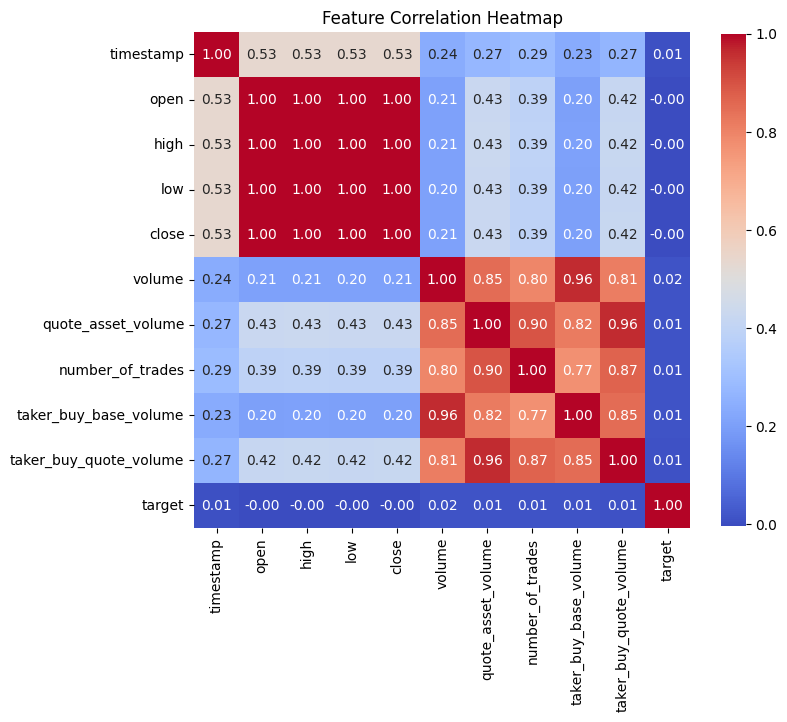

In [14]:
correlation_matrix = train_ori.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap')
plt.show()

**There is strong correlation between- Open, close, High and Low. We will also try to use other Volume related features to see if they are increaing the accuracy**

# Is Data Stationary?

**Next thing we have to check if the data is normally distibuted or not. because it will impact model performance.**

In [ ]:
train=train_ori[:100000]
test=test_ori

train.loc[:,'target'] = (train['close'].shift(-1) > train['close']).astype(int)
#deleting the last row, because its null
train_data = train[:-1].copy()
test_data=test.copy()
train_data.set_index('timestamp', inplace=True)
test_data.set_index('timestamp', inplace=True)

<Axes: xlabel='timestamp'>

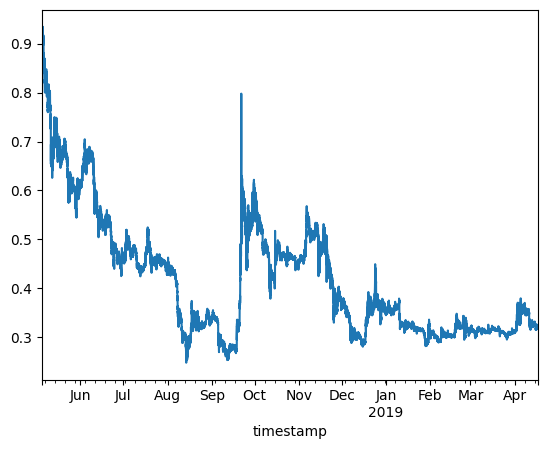

In [20]:
train_data['close'].plot()

**We can see in the above chart that data is not stationary with time. after 2021 there is much ups and downs**

<Axes: xlabel='timestamp'>

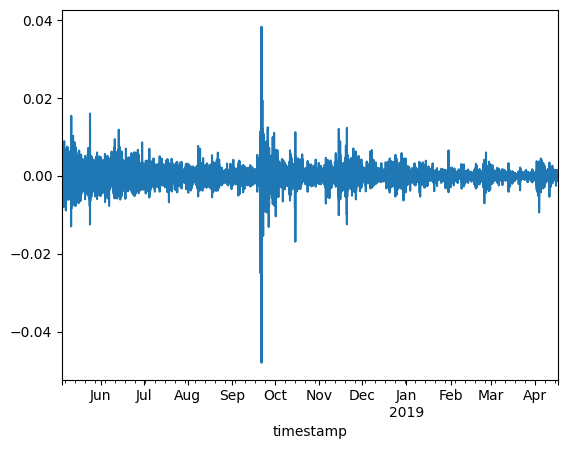

In [21]:
train_data['close_diff'] = train_data['close'].diff().fillna(0) 
train_data['close_diff'].plot()

**Differencing the data makes the data stationary**

**Checking through ADF and PCF plots**

**In ADF if p <.05 then we fail to reject null hypothesis. means data is non stationary. To solve this we will perform few transformations, such as log transform, sma, ma, ema, diff etc**

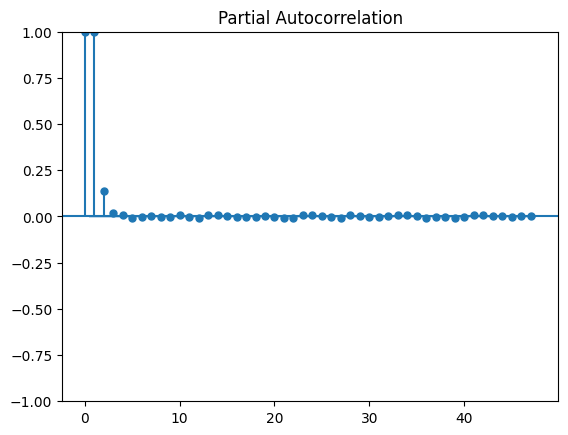

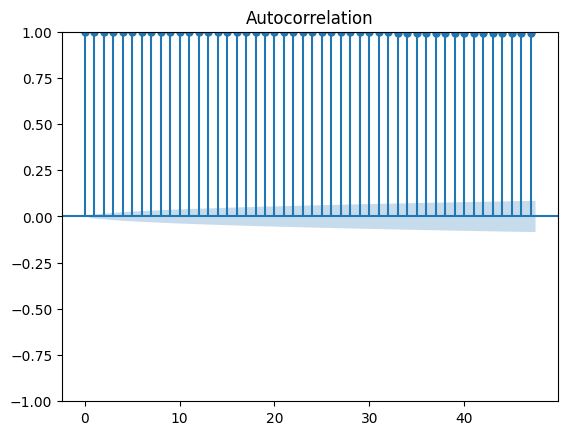

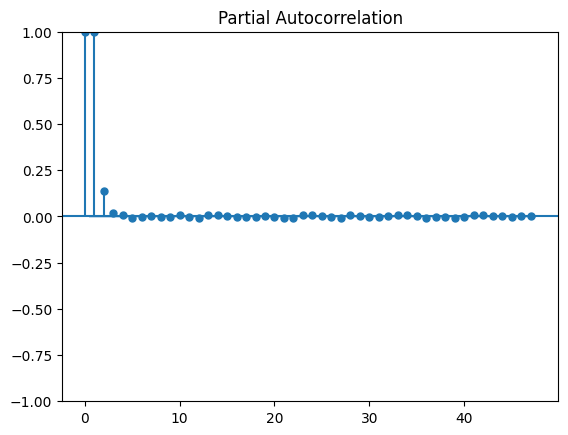

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_data['close'].iloc[:50000])
plot_pacf(train_data['close'].iloc[:50000])


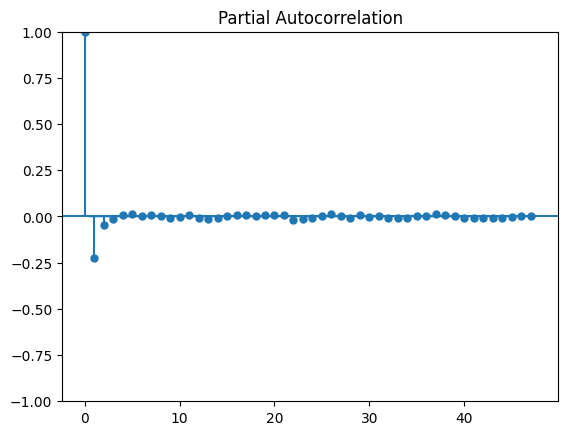

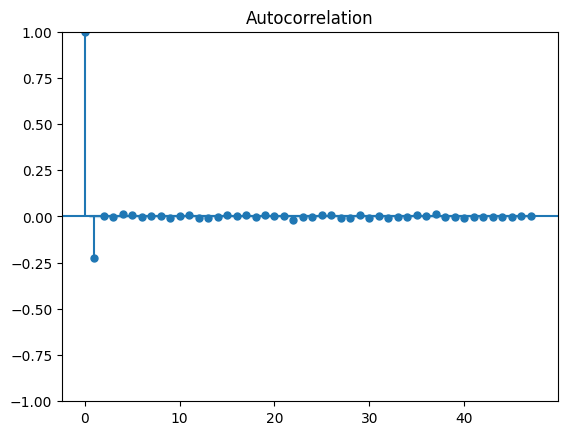

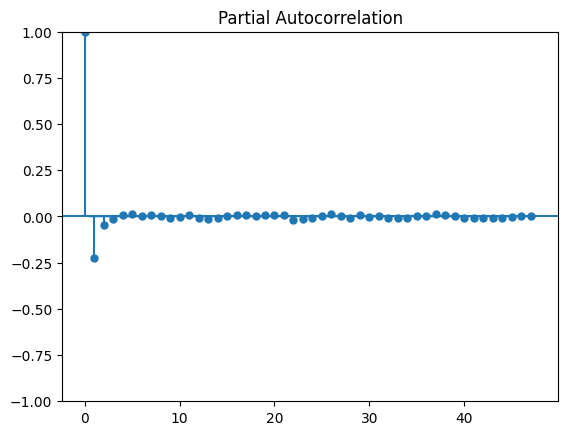

In [23]:
plot_acf(train_data['close_diff'].iloc[:50000])
plot_pacf(train_data['close_diff'].iloc[:50000])

In [26]:
from statsmodels.tsa.stattools import adfuller

adftest_before=adfuller(train_data['close'].iloc[:50000])
adftest_after=adfuller(train_data['close_diff'].iloc[:50000])
print(f'before differencing p value- {adftest_before[1]}')
print(f'after differencing p value- {adftest_after[1]}')     

before differencing p value- 0.09380940960466094
after differencing p value- 0.0


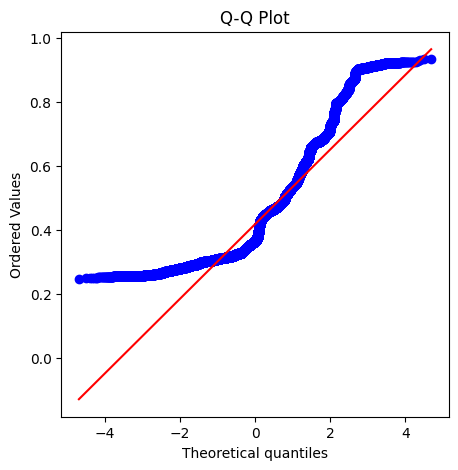

In [27]:
import scipy.stats as stats

plt.figure(figsize=(5, 5))
stats.probplot(train_data['close'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

<Axes: xlabel='timestamp'>

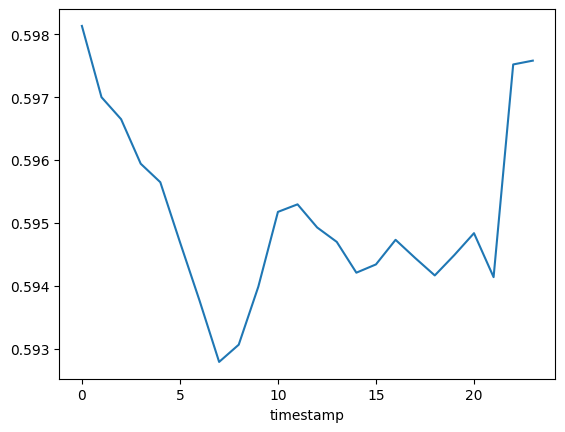

In [421]:
train_data.groupby(train_data.index.hour)['close'].mean().plot()

**Data is deviating from straight line- means its not normally distd. Lets check histogram with kde for better understanding.**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


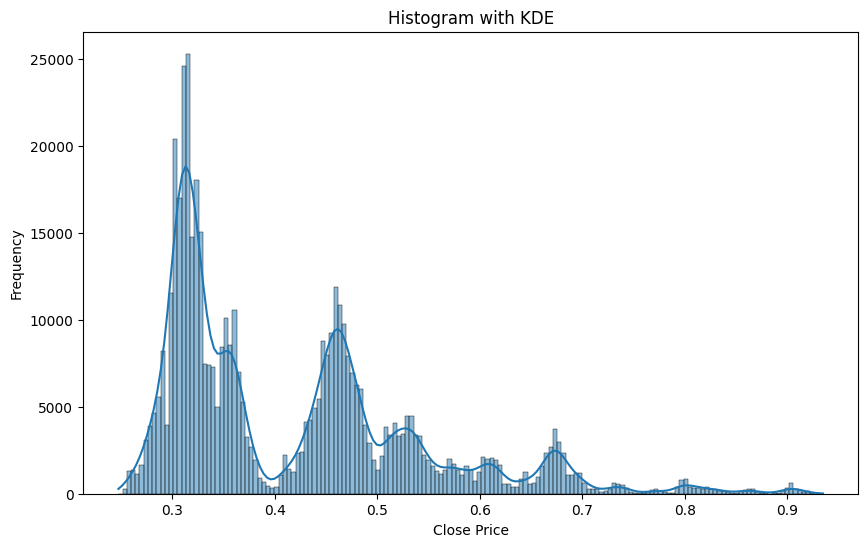

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['close'], kde=True)
plt.title('Histogram with KDE')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

**Clearly Data is right skeweed and not distributed normally. We can either resample the data or perform transformation such as log, sqrt, diff, rolling mean.That will be done in later section.**

# Feature Engineering

In [5]:
from datetime import datetime

In [32]:
#Loading libraries we will need to train models
from sklearn.model_selection import train_test_split

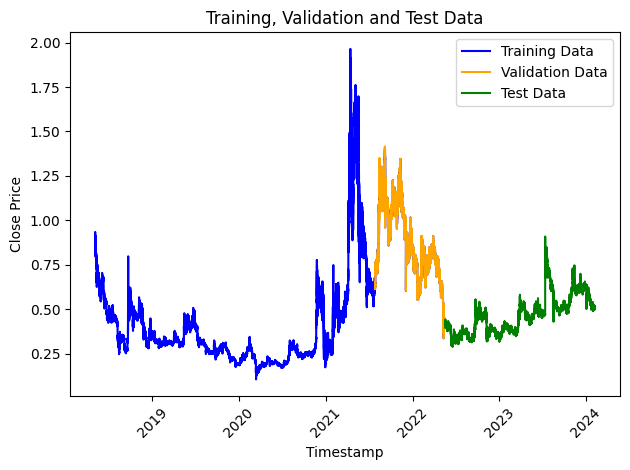

In [33]:
features = ['open', 'high', 'low', 'close', 'volume']
features_col=train_ori.drop(columns=['target']).columns
X_train = train_ori[features]
y_train = train_ori['target']

#Train-Test Split for Validation, We are using 80% as training and 20% as validation data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, 
                                            test_size=0.2, shuffle=False)
# Plot Training Data
plt.plot(train_ori['timestamp'], train_ori['close'], label='Training Data', color='blue')

# Plot Validation Data (last part of training data used as validation)
plt.plot(train_ori['timestamp'][len(train_ori) - len(y_val_split):], 
         train_ori['close'][len(train_ori) - len(y_val_split):], 
         label='Validation Data', color='orange')

# Plot Test Data
plt.plot(test_ori['timestamp'], test_ori['close'], label='Test Data', color='green')

plt.title('Training, Validation and Test Data')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**We can see that this a good train-test split, Our model will be trained on both Low data points as well as High data points. So it can predict pretty well in either case.**

In [30]:
train=train_ori[:100000]
test=test_ori

In [26]:
test['target'] = (test['close'].shift(-1) > test['close']).astype(int)
#test=test[:400000]
#new_test=test[['row_id','target']]'''

In [29]:
test['target'].value_counts()

target
0    527624
1    381993
Name: count, dtype: int64

In [31]:
#Target logic- If tommorow close > today close, mark 1 else 0
train.loc[:,'target'] = (train['close'].shift(-1) > train['close']).astype(int)

In [32]:
#deleting the last row, because its null
train_data = train[:-1].copy()
test_data=test_ori.copy()

In [33]:
train_data.set_index('timestamp', inplace=True)
test_data.set_index('timestamp', inplace=True)

In [34]:
# Extract useful time features from 'timestamp'
train_data.loc[:, 'hour'] = train_data.index.hour
train_data.loc[:, 'minute'] = train_data.index.minute
train_data.loc[:, 'dayofweek'] = train_data.index.dayofweek
train_data.loc[:, 'day'] = train_data.index.day
train_data.loc[:, 'month'] = train_data.index.month

test_data['hour'] = test_data.index.hour
test_data['minute'] = test_data.index.minute
test_data['dayofweek'] = test_data.index.dayofweek
test_data['day'] = test_data.index.day
test_data['month'] = test_data.index.month

**Creating Rolling mean, Rolling Standard Deviation, and EMA**

In [39]:
def create_features(df):

    df['tbvolume_60'] = df['taker_buy_base_volume'].diff(2).fillna(0)
    df['tbvolume'] = df['taker_buy_quote_volume'].diff(5).fillna(0)    
    df['pct_change_close'] = df['close'].pct_change().fillna(0)
    df['pct_change_open'] = df['open'].pct_change().fillna(0)
    df['pct_change_high'] = df['high'].pct_change().fillna(0)
    df['pct_change_low'] = df['low'].pct_change().fillna(0)
    
    
    df['close_diff'] = df['close'].diff(2).fillna(0) 
    df['open_diff'] = df['open'].diff(2).fillna(0)
    
    df['close_std'] = df['close'].rolling(window=10).std().fillna(0)
    df['open_std'] = df['open'].rolling(window=10).std().fillna(0)
    df['close_std_60'] = df['close'].rolling(window=5).std().fillna(0)
    df['momentum_c'] = (df['close_diff'] - df['close_diff'].shift(60)).fillna(0)
    df['momentum_o'] = (df['open_diff'] - df['open_diff'].shift(60)).fillna(0)
    
    df['close_diff_lag_1'] = df['close_diff'].shift(7).fillna(0)
    df['close_diff_lag_2'] = df['close_diff'].shift(14).fillna(0)
    df['close_diff_lag_3'] = df['close_diff'].shift(21).fillna(0)
    
    df['open_diff_lag_1'] = df['open_diff'].shift(7).fillna(0)
    df['open_diff_lag_2'] = df['open_diff'].shift(14).fillna(0)
    df['open_diff_lag_3'] = df['open_diff'].shift(21).fillna(0)
    df['vol_diff_lag_3'] = df['volume'].shift(2).fillna(0)
    
    delta_test = df['open'].diff(2).fillna(0)
    gain_test = (delta_test.where(delta_test > 0, 0)).rolling(window=10).mean().fillna(0)
    loss_test = (-delta_test.where(delta_test < 0, 0)).rolling(window=10).mean().fillna(0)
    rs_test = gain_test / loss_test
    df['rsi_open'] = 100 - (100 / (1 + rs_test)).fillna(0)
    
    return df

In [40]:
train_data = create_features(train_data)
test_data = create_features(test_data)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [41]:
train_series = train_data['close_diff']

In [42]:
train_size = int(len(train_series) * 0.8)
train, valid = train_series[:train_size], train_series[train_size:]

In [43]:
arima_model = ARIMA(train, order=(0, 1, 3))  # (p, d, q) values can be tuned further
arima_fitted = arima_model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


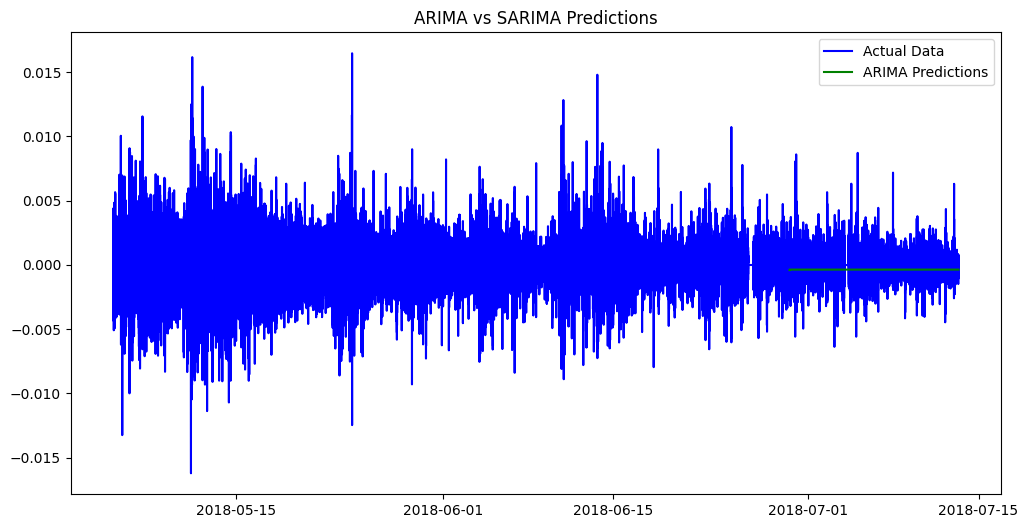

In [44]:
arima_pred = arima_fitted.predict(start=train_size, end=len(train_series)-1, dynamic=False)
#sarima_pred = sarima_fitted.predict(start=train_size, end=len(train_series)-1, dynamic=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Actual Data', color='blue')
plt.plot(valid.index, arima_pred, label='ARIMA Predictions', color='green')
#plt.plot(valid.index, sarima_pred, label='SARIMA Predictions', color='red')
plt.legend()
plt.title('ARIMA vs SARIMA Predictions')
plt.show()

In [45]:
test2_length = len(test_data)

# Forecast with ARIMA model
arima_forecast = arima_fitted.forecast(steps=test2_length)

# Forecast with SARIMA model
#sarima_forecast = sarima_fitted.forecast(steps=test2_length)

# Add the forecasts to the test2 dataframe for comparison
test_data['ARIMA_Predicted_Close'] = arima_forecast.values
#test2_data['SARIMA_Predicted_Close'] = sarima_forecast.values

# Display the first few rows of the test2 data with predictions


In [50]:
test_data['target']= (test_data['ARIMA_Predicted_Close'] > test_data['close'], 1,0).astype(int)

ValueError: Length of values (3) does not match length of index (909617)

In [48]:
test_data['target'].value_counts()

target
0    909617
Name: count, dtype: int64

In [22]:
output=test_data[['row_id', 'target']]

In [25]:
output.shape

(909617, 2)

In [24]:
output.to_csv('submission.csv', index=False)

In [309]:
'''plt.figure(figsize=(14, 7))
# Plot Close Prices
plt.plot(train_data.index, train_data['close'], label='Close Price', color='blue', alpha=0.5)

# Plot Rolling Mean
plt.plot(train_data.index, train_data['rolling_mean'], label='Rolling Mean', color='orange')

# Plot EMA
plt.plot(train_data.index, train_data['EMA_1440'], label='Exponential Moving Average', color='green')

# Customize the plot
plt.title('Close Price with Rolling Mean, Rolling Std Dev and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()'''

"plt.figure(figsize=(14, 7))\n# Plot Close Prices\nplt.plot(train_data.index, train_data['close'], label='Close Price', color='blue', alpha=0.5)\n\n# Plot Rolling Mean\nplt.plot(train_data.index, train_data['rolling_mean'], label='Rolling Mean', color='orange')\n\n# Plot EMA\nplt.plot(train_data.index, train_data['EMA_1440'], label='Exponential Moving Average', color='green')\n\n# Customize the plot\nplt.title('Close Price with Rolling Mean, Rolling Std Dev and EMA')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.legend()\nplt.xticks(rotation=45)\nplt.tight_layout()\n\n# Show the plot\nplt.show()"

# Training Models

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

In [ ]:
'low', 'quote_asset_volume', 'pct_change_close', 'pct_change_high',
       'pct_change_low', 'open_std', 'momentum_c', 'close_diff_lag_2',
       'open_diff_lag_3', 'rsi_open'

In [ ]:
,'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume',
        'hour', 'minute', 'dayofweek', 'day', 'month', 'tbvolume_60',
       'tbvolume', 'pct_change_open', 'open_diff', 'open_std',
        'momentum_c', 'momentum_o', 'close_diff_lag_1',
       'close_diff_lag_2', 'close_diff_lag_3', 'open_diff_lag_1',
       'open_diff_lag_2', 'open_diff_lag_3', 'vol_diff_lag_3' 

In [60]:
#Creating Feature list
features_col=['pct_change_close', 'pct_change_high', 'pct_change_low',
       'open_std', 'momentum_c', 'close_diff_lag_1', 'close_diff_lag_2',
       'vol_diff_lag_3', 'rsi_open']
features=train_data.drop(columns=['target','open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume',
        'hour', 'minute', 'dayofweek']).columns

X = train_data[features_col]
y = train_data['target']
#Train-Test Split for Validation, We are using 80% as training and 20% as validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                            test_size=0.2, shuffle=False)

In [62]:
#standardization of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_data[features_col])
                                 
#X_test_scaled = scaler.transform(test_data.drop(columns=['row_id'])) 

In [40]:
# Fit Lasso regression
lasso = Lasso(alpha=0.01)  # Adjust alpha as needed
lasso.fit(X_train_scaled, y_train)

# Check the coefficients
print("Lasso Coefficients:", lasso.coef_)

# Select features with non-zero coefficients
selected_features = X_train.columns[lasso.coef_ != 0]
print("Selected Features by Lasso:", selected_features)

Lasso Coefficients: [-0.06631774  0.01505988  0.01168847 -0.02253525  0.00351032  0.00504359
  0.01204097]
Selected Features by Lasso: Index(['pct_change_close', 'pct_change_high', 'pct_change_low', 'close_diff',
       'close_std', 'close_std_60', 'rsi_open'],
      dtype='object')


In [51]:
from sklearn.feature_selection import RFE
model1= DecisionTreeClassifier(random_state=42)
rfe = RFE(estimator=model1, n_features_to_select=10) 

In [53]:
rfe.fit(X_train, y_train)
feature_ranking = rfe.ranking_
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)

Selected Features: Index(['tbvolume', 'pct_change_close', 'pct_change_high', 'pct_change_low',
       'open_std', 'momentum_c', 'close_diff_lag_1', 'close_diff_lag_2',
       'vol_diff_lag_3', 'rsi_open'],
      dtype='object')


In [44]:
#Creating list of Models with parameters
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=30, max_depth=10,criterion='entropy'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': xgb.XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.2, max_depth=6)
}

In [ ]:
# Train, Predict, and Evaluate Models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)

    # Macro-Averaged F1 Score
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    print(f"{model_name} Macro-Averaged F1 Score: {f1_macro:.4f}")
    print(classification_report(y_val, y_val_pred))

Training Decision Tree...
Decision Tree Macro-Averaged F1 Score: 0.5485
              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61     11209
         1.0       0.50      0.48      0.49      8791

    accuracy                           0.56     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.56      0.56     20000

Training Random Forest...


In [323]:
#Predictions for test set using the best model
best_model = models['Decision Tree']
X_test=test_data[features]
y_test_pred = best_model.predict(X_test_scaled)

#Saving in csv
output = pd.DataFrame({
    'row_id': test_data['row_id'], 
    'target': y_test_pred
})
new_df=output[-509617:]
result=pd.concat((new_test,new_df), axis=0)
result.to_csv('submission.csv', index=False)

# Feature Importance

In [46]:
model=DecisionTreeClassifier()
#model=xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = model.feature_importances_

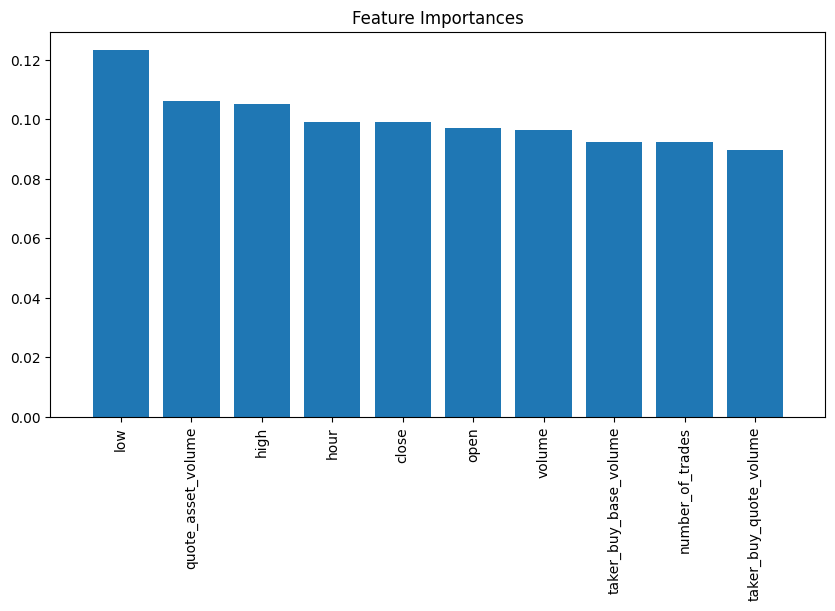

In [47]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# LSTM Modelling

In [57]:
train_data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume',
       'target', 'hour', 'minute', 'dayofweek', 'day', 'month', 'tbvolume_60',
       'tbvolume', 'pct_change_close', 'pct_change_open', 'pct_change_high',
       'pct_change_low', 'close_diff', 'open_diff', 'close_std', 'open_std',
       'close_std_60', 'momentum_c', 'momentum_o', 'close_diff_lag_1',
       'close_diff_lag_2', 'close_diff_lag_3', 'open_diff_lag_1',
       'open_diff_lag_2', 'open_diff_lag_3', 'vol_diff_lag_3', 'rsi_open'],
      dtype='object')

In [107]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [108]:
# Reshape data for LSTM (samples, time steps, features)
X_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [109]:
# Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the LSTM Model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM Model
lstm_model.fit(X_lstm[:len(y_train)], y_train.values, epochs=25, batch_size=32)

Epoch 1/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6014 - loss: 0.6615
Epoch 2/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6234 - loss: 0.6461
Epoch 3/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6306 - loss: 0.6399
Epoch 4/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6349 - loss: 0.6357
Epoch 5/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6371 - loss: 0.6327
Epoch 6/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6414 - loss: 0.6321
Epoch 7/25
2408/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6392 - loss: 0.6312

In [111]:
# Reshape test data for LSTM (samples, time steps, features)
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
y_test_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.7).astype(int)

# Print predictions for test data from LSTM
print("Predicted values from LSTM on test data:")
print(y_test_pred_lstm.flatten())

22955/28426 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

In [113]:
submission_lstm = pd.DataFrame({'row_id': test_data['row_id'], 'target': y_test_pred_lstm.flatten()})
#submission_lstm.to_csv('submission_lstm.csv', index=False)

# Hyperparameter Tuning

In [96]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [116]:
# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [20,40, 60],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
''''rf_model=RandomForestClassifier()
#Random Forest grid search
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, scoring='accuracy', cv=5)
rf_grid_search.fit(X_train_scaled, y_train)'''

In [ ]:
'''# Best parameters and estimator from grid search for Random Forest

best_rf_params = rf_grid_search.best_params_
best_rf_model = rf_grid_search.best_estimator_

print(f"Best parameters for Random Forest: {best_rf_params}")
'''

In [ ]:
'''# Validate the best Random Forest Model
y_val_pred_rf = best_rf_model.predict(X_val_scaled)
rf_accuracy = accuracy_score(y_val_split, y_val_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
'''

In [ ]:
# Step 8: Prepare Test Data for Predictions using all models (including tuned models)

#X_test = test_data[features]
#X_test_scaled = scaler.transform(X_test)  # Scale test data using the same scaler

# Make predictions on test data using the tuned models
#y_test_pred_rf = best_rf_model.predict(X_test_scaled)
#print("\nPredicted values from Tuned Random Forest on test data:")
#print(y_test_pred_rf)



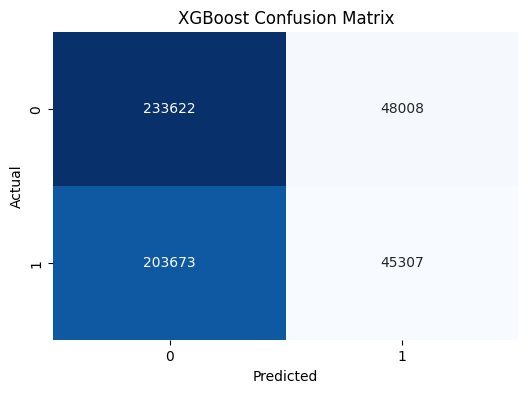

In [164]:
'''  # Confusion Matrix Visualization
cm = confusion_matrix(y_val_split, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"{model_name} Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()'''